<a href="https://colab.research.google.com/github/rulas99/rl_uniandes/blob/main/irl_apprenticeship_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
# Definimos el gridworld de 5x4
grid_size = (4, 5)

# Definimos el estado objetivo
goal_state = (2, 0)

# Trayectorias observadas del experto (τ₁, τ₂, τ₃)
expert_trajectories = [
    [(0,0), (0,1), (0,2), (0,3), (0,4), (1,4), (2,4), (3,4), (3,3), (3,2), (3,1), (2,1), (2,0)],
    [(0,0), (0,1), (0,2), (0,3), (0,4), (1,4), (2,4), (3,4), (3,3), (3,2), (3,1), (3,0), (2,0)],
    [(0,0), (0,1), (0,2), (0,3), (0,4), (1,4), (2,4), (3,4), (3,3), (3,2), (3,1), (2,1), (2,0)],
]


# Definimos los estados y acciones posibles
states = [(x, y) for x in range(grid_size[0]) for y in range(grid_size[1])]
actions = {
    0: (0, -1),   # Arriba
    1: (0, 1),    # Abajo
    2: (-1, 0),   # Izquierda
    3: (1, 0)     # Derecha
}
action_names = {
    0: 'U',
    1: 'D',
    2: 'L',
    3: 'R'
}



def calculate_expert_state_visitation_frequency(trajectories):
    state_counts = {state: 0 for state in states}
    total_visits = 0
    for trajectory in trajectories:
        for n, state in enumerate(trajectory):
            state_counts[state] += 1 * n
            total_visits += 1
    # Normalizar las frecuencias
    for state in state_counts:
        state_counts[state] /= total_visits

    # Normalizar por minmax
    max_count = max(state_counts.values())
    min_count = min(state_counts.values())
    for state in state_counts:
        state_counts[state] = (state_counts[state] - min_count) / (max_count - min_count)

    return state_counts


# Creamos un diccionario con las características de cada estado basadas en la frecuencia de visita del experto
expert_state_frequencies = calculate_expert_state_visitation_frequency(expert_trajectories)

def feature_vector(state):
    # La característica es la frecuencia de visita del estado por el experto
    freq = np.array([expert_state_frequencies[state]])

    # Manhattan distance
    #max_distance = grid_size[0] + grid_size[1] - 2
    #distance = abs(state[0] - goal_state[0]) + abs(state[1] - goal_state[1])
    #normalized_distance = np.array([distance / max_distance])

    return freq #* normalized_distance

# Inicialización de θ (theta)
theta = np.array([0.1])  # Valor inicial de theta

# Función de recompensa rφ(s) = θ⋅φ(s)
def reward(state, theta):
    if state == goal_state:
        return 1.0
    return (theta * feature_vector(state)).item()

# Cálculo de las expectativas de características μ=(1/N)∑τ∑tφ(sτ_t)
def calculate_feature_expectations(trajectories):
    feature_expectations = np.zeros(1)
    total_steps = sum(len(traj) for traj in trajectories) # N
    for trajectory in trajectories: # τ
        for state in trajectory: # sτ_t
            feature_expectations += feature_vector(state)
    return feature_expectations / total_steps

# μE
expert_feature_expectations = calculate_feature_expectations(expert_trajectories)


print("Expectativas de características del experto:", expert_feature_expectations)

# Parámetros para Apprenticeship Learning
num_iterations = 10
epsilon = 0.3        # Parámetro epsilon de aleatoriedad para la estrategia epsilon-greedy
learning_rate = 0.1  # Tasa de aprendizaje para actualizar theta
alpha = 0.1          # Tasa de aprendizaje para Q-learning

gamma = 0.25          # Factor de descuento γ: pondera las recompensas futuras en la actualización de Q. Mayor γ valora más las recompensas futuras.

# Función para obtener el siguiente estado dado un estado y una acción
def get_next_state(state, action):
    dx, dy = actions[action]
    nx, ny = state[0] + dx, state[1] + dy
    if 0 <= nx < grid_size[0] and 0 <= ny < grid_size[1]:
        return (nx, ny)
    else:
        return state  # Si sale del grid, se queda en el mismo estado

# Función para elegir una acción usando la estrategia epsilon-greedy
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(list(actions.keys()))
    else:
        # Seleccionar la acción con el valor Q máximo
        q_values = [Q[state, a] for a in actions]
        max_q = np.max(q_values)
        max_actions = [a for a in actions if Q[state, a] == max_q]
        return np.random.choice(max_actions)

# Inicializamos la tabla Q
def initialize_Q():
    Q = {}
    for state in states:
        for action in actions:
            Q[state, action] = 0.0
    return Q

# Función para simular trayectorias del agente
def simulate_trajectories(Q, num_trajectories):
    trajectories = []
    for _ in range(num_trajectories):
        trajectory = []
        state = (0, 0)  # Estado inicial
        trajectory.append(state)
        steps = 0
        while state != goal_state and steps < 100:
            action = epsilon_greedy_policy(Q, state, epsilon=0.0)  # Usamos la política aprendida
            next_state = get_next_state(state, action)
            trajectory.append(next_state)
            state = next_state
            steps += 1
        trajectories.append(trajectory)
    return trajectories

def train_Q(Q, alpha, gamma, num_episodes):
    for episode in range(num_episodes):
        state = (0, 0)
        steps = 0
        while state != goal_state and steps < 100:
            action = epsilon_greedy_policy(Q, state, epsilon)
            next_state = get_next_state(state, action)
            r = reward(next_state, theta)
            # Actualización de Q-learning
            if next_state != state:
                q_values_next = [Q[next_state, a] for a in actions]
                td_target = r + gamma * max(q_values_next)
                td_error = td_target - Q[state, action]
                Q[state, action] += alpha * td_error
            else:
                Q[state, action] = 0
            state = next_state
            steps += 1
            
    return Q
    

# Bucle principal de Apprenticeship Learning
for iteration in tqdm(range(num_iterations)):
    # Inicializamos la tabla Q para esta iteración
    Q = initialize_Q()

    # Entrenamos al agente usando Q-learning con la recompensa actual
    Q = train_Q(Q, alpha, gamma, num_episodes=100)

    # Generamos trayectorias siguiendo la política aprendida con Q-learning usando la 
    # función de recompensa actualizada
    agent_trajectories = simulate_trajectories(Q, num_trajectories=len(expert_trajectories))

    # Calculamos las expectativas de características del agente
    agent_feature_expectations = calculate_feature_expectations(agent_trajectories)

    # Diferencia de características entre el experto y el agente μE ​− μ
    feature_difference = expert_feature_expectations - agent_feature_expectations

    # Ajuste de θ para minimizar la diferencia
    theta += learning_rate * feature_difference
    
# Resultado final
print("Parámetro de recompensa óptimo (theta):", theta)

# Visualización de la función de recompensa obtenida para cada estado
reward_grid = np.zeros(grid_size)
for x in range(grid_size[0]):
    for y in range(grid_size[1]):
        state = (x, y)
        reward_value = reward(state, theta)  # Pasamos theta a la función reward
        reward_grid[x, y] = reward_value

print("Función de recompensa obtenida para cada estado:")
print(np.round(reward_grid, 2))

# Visualización de una trayectoria del agente
def plot_trajectory(trajectory, title="Trayectoria"):
    grid = np.zeros(grid_size)
    for state in trajectory:
        grid[state] = 1
    plt.figure(figsize=(6, 5))
    sns.heatmap(grid, cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Posición X')
    plt.ylabel('Posición Y')
    plt.show()


Expectativas de características del experto: [0.46866097]


100%|██████████| 10/10 [00:00<00:00, 42.12it/s]

Parámetro de recompensa óptimo (theta): [0.19237892]
Función de recompensa obtenida para cada estado:
[[0.   0.02 0.03 0.05 0.06]
 [0.   0.   0.   0.   0.08]
 [1.   0.12 0.   0.   0.1 ]
 [0.06 0.16 0.14 0.13 0.11]]


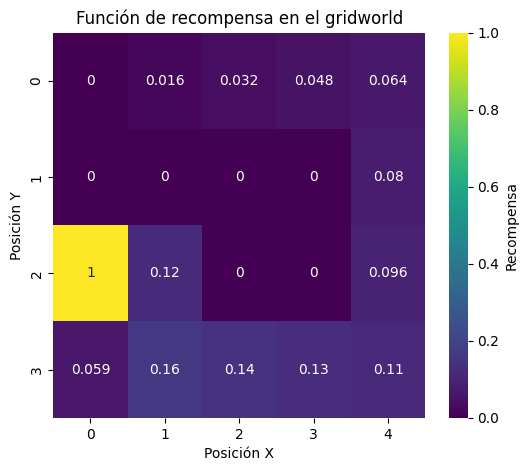

In [113]:
# Visualización con heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(reward_grid, annot=True, cmap='viridis', cbar_kws={'label': 'Recompensa'})
plt.title('Función de recompensa en el gridworld')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
plt.show()

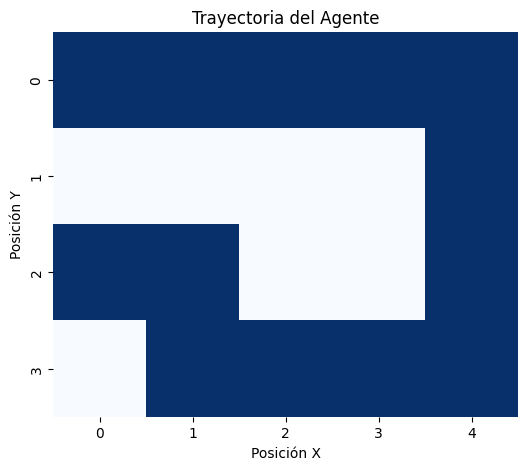

In [114]:
# Visualizar una trayectoria del agente
plot_trajectory(agent_trajectories[0], title="Trayectoria del Agente")

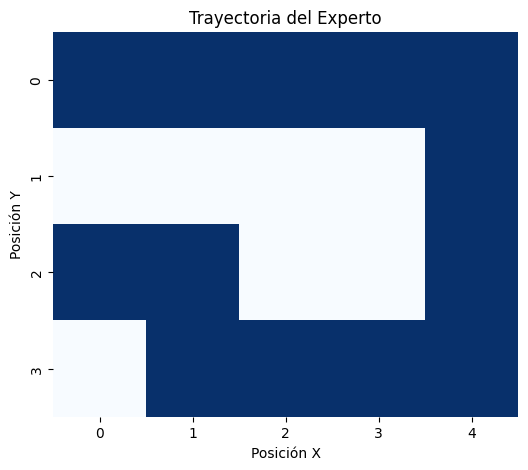

In [115]:
# Visualizar la trayectoria del experto
plot_trajectory(expert_trajectories[0], title="Trayectoria del Experto")